# Dense Neural Network
A dense NN is also called a Fully Connected (FC) or Multi-Layer Perceptron (MLP).   

## Architecture
The network consists of layers which consist of neurons.

Layers:    
The neural network architecture is: 
Input Layer that reads features | 
Internal Layer(s) that have trainable weights | 
Output Layer that produces scores.
The input layer should have one neuron per feature of the input vector.
The output layer should have one neuron per label that needs to be predicted.
A deep NN has many internal layers.

Neurons:    
Each layer consists of Neurons.
Neurons consist of Weighted Inputs | Summation | Activation Function | Output.
With non-linear activations, the network can model any non-linear function.
Each neuron also has one weighted input called the bias.
The bias is merely for scaling the output, 
equivalent to the y-intercept b in the linear equation y=mx+b.

MLP:    
In the MLP architecture, 
neurons have no connections to other neurons in the same layer,
but they are connected to every neuron in the layers immediately before and after.



## Training
Trainable parameters:  
The model as trainable weights on every edge.
The weights are initialized randomly (e.g. by the glorot_uniform algorithm).

One forward calculation:  
The model is shown one data instance from the labeled training set.
Using the weights and activations, the output scores are computed.

One back propagation:   
For each labeled training instance, the actual scores are known.
A loss function is applied to the calculated as actual minus difference.
The partial derivative of the loss, with respect to each input, provides a gradient.
The gradient tells the amount and direction that each input contributed to the loss.
Using partial derivatives of the activations,
the total loss is distributed, such that every neuron accepts some portion of the loss. 
Finally, the weight of each neuron's output is updated
in the opposite direction of the gradient, so as to reduce the loss.
The size of the update can be controlled by a learn rate parameter.

Gradient descent:   
The back propagation can apply to the loss over any number of instances, called a batch.
If the batch size is 1, and each next training instance is chosen randomly,
that is called "stochastic gradient descent."
If the batch size equals the whole training set,
that is called "batch gradient descent" but it is computationally prohibitive.
In keras, the default batch size is 32, 
and instances within each batch are used in random order.

Epoch:   
When all the training samples have been used once, the model has been trained for one epoch.
It is usually necessary to train a model for many epochs.

## Evaluation
Validiation cycles:   
We train a model on a training set.
We evaluate the model on a separate validation set.
In cycles, we adjust the model architecture and hyperparameters
until the validation accuracy looks good.
Finally, we measure the true accuracy on the previously-unused test data.

Test set:   
Some portion of the data, maybe 20%, is set aside for post-training evaluation.
It is very important to avoid looking within the test set.
Otherwise, the model accuracy could be artificially and inadvertently inflated.

Validation set:   
Some portion of the remaining data, maybe 20%, is set aside for hyperparameter tuning.
For instance, should the deep neural network have 10 layers or 20?
The model gets trained and evaluated and then tuned in cycles.
It is important to avoid using any validation data for training, and vice-versa.
Otherwise, the validation accuracy could be inflated.

Training set:   
After removing the test and validation data, the training set is what remains.

Cross validation:   
This is used to alleviate a data shortage,
when we would rather not have to set aside a validation set.
In 5-fold cross-validation, we make 5 mutually exclusive partions,
of 80% train and 20% valid. 
Each data instaince will be used 4 times for training and 1 time for validation.
The total validation accuracy is the mean of 5 rounds of training & validation.
After model tuning is complete, the full dataset is used to retrain the model.
The model thus trained is then evaluated on the previously-unseen test set.

In [1]:
import datetime
print(datetime.datetime.now())
from platform import python_version
print('Python',python_version())
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2022-09-05 18:10:52.124955
Python 3.10.0


In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import StratifiedKFold

## The Dataset
Iris:   
We'll use the Iris dataset,
famous because it was used in a regression paper by R.A. Fisher.
There are 150 data instances, each a flower with 4 numeric features.
Each instance is one of 3 species, labled 0, 1, 2.

Shuffle:  
The data are provided in order (0s first, 2s last).
We must avoid training on 0s and testing on 2s, so we shuffle the rows.
In our experiments on this page, the shuffle step was critical.

In [3]:
from sklearn import datasets
from sklearn.utils import shuffle
iris = datasets.load_iris()
print('shape',iris.data.shape)
print('features',iris.feature_names)
print('labels',iris.target_names)
X = iris.data
y = iris.target
# At start, all species=0 come first and all species=2 come last.
# Important to shuffle rows before doing train/test split and train/valid split.
# Another way is using the sklearn train_test_split class.
X, y = shuffle(X, y)   # add this for reproducible results: random_state=0
print('X shape',X.shape)
print('y shape',y.shape)
num_instances = X.shape[0]
num_features =  X.shape[1]
num_labels = len(np.unique(y))

shape (150, 4)
features ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
labels ['setosa' 'versicolor' 'virginica']
X shape (150, 4)
y shape (150,)


## Set aside the test set
For the final test, we set aside 10% of the data as unseen.
Since the rows were previously shuffled, the last 10% is a random subset.

In [4]:
UNSEEN_PORTION = 0.10
split_point = int ( X.shape[0] * (1-UNSEEN_PORTION) )
# Tensors don't support slice. Use numpy array here, tensor later.
X_unseen = np.array(X)[split_point:]
y_unseen = np.array(y)[split_point:]
X_seen   = np.array(X)[:split_point]
y_seen   = np.array(y)[:split_point]

In [5]:
# Here are the species labels. Each y corresponds to a row of X_seen.
y_seen[:10]

array([2, 1, 1, 1, 2, 0, 1, 0, 2, 2])

In [6]:
# Here is the raw data, row-shuffled but not normalized.
X_seen[:10]

array([[6.7, 3. , 5.2, 2.3],
       [5.5, 2.4, 3.7, 1. ],
       [6.3, 2.3, 4.4, 1.3],
       [5.7, 2.8, 4.1, 1.3],
       [6.9, 3.2, 5.7, 2.3],
       [5.3, 3.7, 1.5, 0.2],
       [5.6, 2.5, 3.9, 1.1],
       [4.8, 3.4, 1.6, 0.2],
       [5.6, 2.8, 4.9, 2. ],
       [6.9, 3.1, 5.1, 2.3]])

## Normalization
Without normalization, the feature with biggest variance dominates.  
We use the Keras Normalization class:
1. Constructor takes axis, mean, var. By default, axis = -1 (the last axis), mean=0, var=1.
1. The adapt() method tunes the scaling parameters to the given data.
1. From then on, the object scales any given data.
1. Importantly, we adapt() to the training data and apply to the test data.

In [7]:
normalizer = layers.Normalization() 
normalizer.adapt(X_seen)   # adapt to the training data only
X_seen = normalizer(X_seen)
X_unseen = normalizer(X_unseen)
# Here are the normalized feature values.
X_seen[:10]

2022-09-05 18:11:04.189281: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[ 1.0330249 , -0.11624681,  0.83755577,  1.4887536 ],
       [-0.3900197 , -1.4808929 , -0.01216878, -0.23698092],
       [ 0.5586771 , -1.7083342 ,  0.38436943,  0.16126546],
       [-0.15284579, -0.571129  ,  0.21442439,  0.16126546],
       [ 1.2701994 ,  0.33863539,  1.1207974 ,  1.4887536 ],
       [-0.6271936 ,  1.4758406 , -1.2584317 , -1.2989714 ],
       [-0.27143276, -1.2534521 ,  0.10112787, -0.10423207],
       [-1.220129  ,  0.7935176 , -1.2017834 , -1.2989714 ],
       [-0.27143276, -0.571129  ,  0.667611  ,  1.0905073 ],
       [ 1.2701994 ,  0.11119401,  0.7809075 ,  1.4887536 ]],
      dtype=float32)>

## Model Architecture
Here we decide number of layers, number of neurons per layer, and activation functions.
Deciding this is an artform. 
In fact, we played with several settings before settling on the ones shown here. 

Keras offers 2 means of building a model.
Both use [model](https://www.tensorflow.org/api_docs/python/tf/keras/Model).  
1. The [Sequential class](https://keras.io/api/models/sequential/#sequential-class) is simple. It has an add(layer) method. It maintains layers in the order they were added. It allows linear models only. Every layer has one input and one output.
1. The [Functional API](https://keras.io/guides/functional_api/) is complex. It allows DAG models. Layers can be skipped, reused, and multiply connected. We use the Functional API even though our model is linear in this example.

The Keras Dense layer class has these constructor options.
1. num units
1. activation. Default=linear. Choices are relu, elu, softplus (smooth relu), softmax, sigmoid, tanh, exponential. There is an API so you can build your own.
1. use_bias. Default=True
1. kernel_initializer. Default="glorot_uniform"
1. regularizers for the bias, kernel, and activity. Default=None.

Our model:    
Our model will have 2 internal layers with 8 neurons each.
Our input layer has the same shape as the features: 1x4.
Our output layer has the same shape as the labels: 3x1.

In [8]:
def make_model(name):
    # Don't specify the shape's number of rows. That varies between validation & testing.
    # Keras output layer raises exception unless #neurons == #labels in Y.
    DROPOUT = 0.20
    NEURONS = 8
    inputs  =  keras.Input(shape=(num_features,))
    prev    =  inputs
    prev    =  layers.Dense(NEURONS, activation="relu")       (prev)
    prev    =  layers.Dropout(DROPOUT)                        (prev)
    prev    =  layers.Dense(NEURONS, activation="relu")       (prev)
    outputs =  layers.Dense(num_labels, activation="softmax") (prev)
    new_model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    #loss='categorical_crossentropy',optimizer='adam',
    #loss=keras.losses.SparseCategoricalCrossentropy(),optimizer=keras.optimizers.RMSprop(),
    new_model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(),optimizer=keras.optimizers.RMSprop(),
        metrics=["accuracy"])
    return new_model

## Count the trainable parameters
Here we explain the number of trainable parameters that are shown below.
1. Dense_0: (4 input + 1 bias) * 8 out = 40 
1. Dense_0: (8 input + 1 bias) * 8 out = 72 
1. Dense_2: (8 input + 1 bias) * 3 out = 27

In [9]:
demo = make_model("Demo")
demo.summary()

Model: "Demo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 8)                 40        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 3)                 27        
                                                                 
Total params: 139
Trainable params: 139
Non-trainable params: 0
_________________________________________________________________


## Training and Validation
We use the process documented at [Keras models](https://keras.io/api/models/).

Train:    
This is implemented by the Keras model.fit() function.
We call it 5 times in a loop.
We give it the training data and the validation data.
For training, it uses the training data exclusively.
For validation, it uses the validation data exclusively.
So, for example, dropout regularization 
is applied to learning from the training data 
but not to evaluating on the validation data.

Validate:    
This is emplemented by the Keras model.evaluate() function.
We call it 5 times in a loop.

Cross Validation:   
We evaluate the model by 5-fold cross validation.
We use "stratified" KFold so that each validation set
has approximately the same number of each label (flower species).

In 5 iterations of the loop, we will:    
1. Re-build the model. Otherwise each loop would additively improve the same model. Can you guess how I figured that out?
2. Fit the model to the training data by adjusting parameters. In Keras, model.fit() is made to be customized, but we use it as is. Thanks to the default shuffle=True, model.fit() 
shuffles each batch before training on it. 
3. Evaluate the model on the validation data. This is must faster than traing. Using the forward computation only, we compute a score for each validation instance.

In [10]:
# Use seen data only. Do not peek at unseen data.
EPOCHS=30
SPLITS=5
fold=0
skf = StratifiedKFold(n_splits=SPLITS)
history_vector=[None]*SPLITS
valid_vector  =[None]*SPLITS
def tensor_slice(tensor,index):
    array = np.array(tensor)
    subset = array[index]
    tensor = tf.convert_to_tensor(subset)
    return tensor
for train, valid in skf.split(X_seen,y_seen):
    X_train = tensor_slice(X_seen,train)
    y_train = tensor_slice(y_seen,train)
    X_valid = tensor_slice(X_seen,valid)
    y_valid = tensor_slice(y_seen,valid)
    validata = (X_valid,y_valid)
    name = "MLP_"+str(fold)
    fold_model  = make_model(name)
    fold_history = fold_model.fit(X_train,y_train,
                                  batch_size=25,epochs=EPOCHS,validation_data=validata)
    # The call to evaluate() is redundant with fit(validation_data),
    # but it provides a quick & easy way to get the final validation scores.
    fold_valid = None
    fold_valid = fold_model.evaluate(X_valid, y_valid)
    history_vector[fold]=fold_history
    valid_vector  [fold]=fold_valid
    fold += 1
    print("Fold", fold,"Valid accuracy:",fold_valid[1],"Valid loss:", fold_valid[0])

Epoch 1/30
5/5 [==============================] - 1s 65ms/step - loss: 1.0746 - accuracy: 0.1852 - val_loss: 1.0034 - val_accuracy: 0.5185
Epoch 2/30
5/5 [==============================] - 0s 12ms/step - loss: 1.0820 - accuracy: 0.2500 - val_loss: 0.9879 - val_accuracy: 0.5556
Epoch 3/30
5/5 [==============================] - 0s 13ms/step - loss: 1.0341 - accuracy: 0.4352 - val_loss: 0.9745 - val_accuracy: 0.6296
Epoch 4/30
5/5 [==============================] - 0s 13ms/step - loss: 1.0555 - accuracy: 0.3426 - val_loss: 0.9638 - val_accuracy: 0.6296
Epoch 5/30
5/5 [==============================] - 0s 17ms/step - loss: 1.0415 - accuracy: 0.4074 - val_loss: 0.9536 - val_accuracy: 0.6667
Epoch 6/30
5/5 [==============================] - 0s 12ms/step - loss: 0.9946 - accuracy: 0.5185 - val_loss: 0.9433 - val_accuracy: 0.6667
Epoch 7/30
5/5 [==============================] - 0s 12ms/step - loss: 0.9961 - accuracy: 0.5185 - val_loss: 0.9310 - val_accuracy: 0.6667
Epoch 8/30
5/5 [===========

5/5 [==============================] - 0s 16ms/step - loss: 0.5239 - accuracy: 0.8426 - val_loss: 0.5150 - val_accuracy: 0.7037
Epoch 29/30
5/5 [==============================] - 0s 18ms/step - loss: 0.5015 - accuracy: 0.7870 - val_loss: 0.5079 - val_accuracy: 0.7037
Epoch 30/30
1/1 [==============================] - 0s 18ms/step - loss: 0.4964 - accuracy: 0.7407
Fold 2 Valid accuracy: 0.7407407164573669 Valid loss: 0.4964400827884674
Epoch 1/30
5/5 [==============================] - 1s 51ms/step - loss: 1.0630 - accuracy: 0.5463 - val_loss: 0.9766 - val_accuracy: 0.5926
Epoch 2/30
5/5 [==============================] - 0s 12ms/step - loss: 1.0226 - accuracy: 0.5278 - val_loss: 0.9570 - val_accuracy: 0.6296
Epoch 3/30
5/5 [==============================] - 0s 11ms/step - loss: 0.9897 - accuracy: 0.5741 - val_loss: 0.9429 - val_accuracy: 0.6667
Epoch 4/30
5/5 [==============================] - 0s 11ms/step - loss: 0.9780 - accuracy: 0.5926 - val_loss: 0.9270 - val_accuracy: 0.6667
Epoch

5/5 [==============================] - 0s 8ms/step - loss: 1.0000 - accuracy: 0.6111 - val_loss: 0.9406 - val_accuracy: 0.6296
Epoch 25/30
5/5 [==============================] - 0s 9ms/step - loss: 0.9685 - accuracy: 0.6481 - val_loss: 0.9296 - val_accuracy: 0.6296
Epoch 26/30
5/5 [==============================] - 0s 9ms/step - loss: 0.9865 - accuracy: 0.6204 - val_loss: 0.9220 - val_accuracy: 0.6667
Epoch 27/30
5/5 [==============================] - 0s 8ms/step - loss: 0.9514 - accuracy: 0.6574 - val_loss: 0.9117 - val_accuracy: 0.6667
Epoch 28/30
5/5 [==============================] - 0s 9ms/step - loss: 0.9478 - accuracy: 0.6111 - val_loss: 0.9017 - val_accuracy: 0.6667
Epoch 29/30
5/5 [==============================] - 0s 8ms/step - loss: 0.9433 - accuracy: 0.6389 - val_loss: 0.8915 - val_accuracy: 0.7037
Epoch 30/30
1/1 [==============================] - 0s 19ms/step - loss: 0.8812 - accuracy: 0.7037
Fold 4 Valid accuracy: 0.7037037014961243 Valid loss: 0.8812013268470764
Epoch 1

## Summarize the training and validation 
Within each round of cross valication,
after each epoch,
we measured train accuracy, train loss, validation accuracy, validation loss.
Now they can be plotted over time.

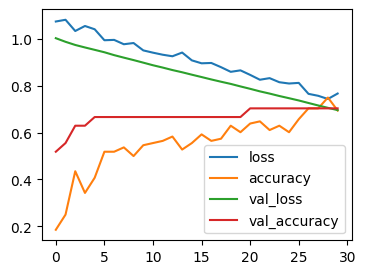

Fold 1 Final Validation acc = 0.70 loss =0.70


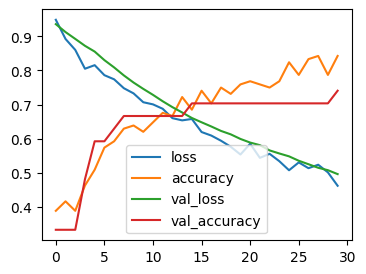

Fold 2 Final Validation acc = 0.74 loss =0.50


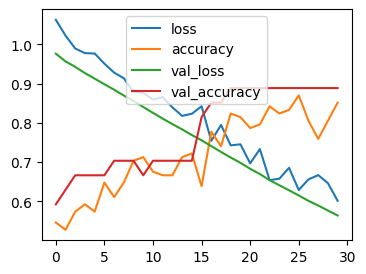

Fold 3 Final Validation acc = 0.89 loss =0.56


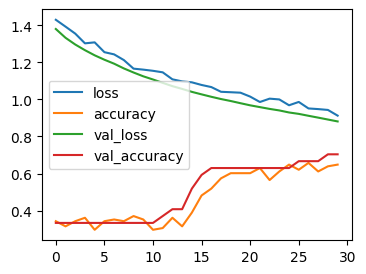

Fold 4 Final Validation acc = 0.70 loss =0.88


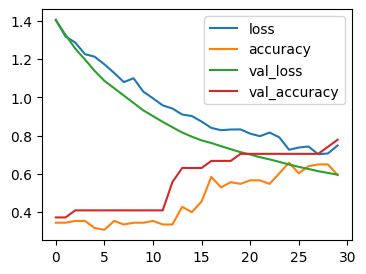

Fold 5 Final Validation acc = 0.78 loss =0.59


In [11]:
for fold in range(SPLITS):
    one_history = history_vector[fold]
    pair = valid_vector[fold]
    pd.DataFrame(one_history.history).plot(figsize=(4,3))
    plt.show()
    print('Fold %d Final Validation acc = %.2f loss =%.2f'%(fold+1,pair[1],pair[0]))

# Finally, compute test accuracy
Do this only after settling on the model hyperparameters once and for all.

Epoch 1/30
6/6 [==============================] - 1s 2ms/step - loss: 1.0929 - accuracy: 0.2222
Epoch 2/30
6/6 [==============================] - 0s 4ms/step - loss: 1.0691 - accuracy: 0.2889
Epoch 3/30
6/6 [==============================] - 0s 5ms/step - loss: 1.0316 - accuracy: 0.3926
Epoch 4/30
6/6 [==============================] - 0s 4ms/step - loss: 1.0149 - accuracy: 0.4148
Epoch 5/30
6/6 [==============================] - 0s 4ms/step - loss: 0.9776 - accuracy: 0.5185
Epoch 6/30
6/6 [==============================] - 0s 4ms/step - loss: 0.9652 - accuracy: 0.5481
Epoch 7/30
6/6 [==============================] - 0s 4ms/step - loss: 0.9485 - accuracy: 0.5333
Epoch 8/30
6/6 [==============================] - 0s 4ms/step - loss: 0.9351 - accuracy: 0.6000
Epoch 9/30
6/6 [==============================] - 0s 5ms/step - loss: 0.9139 - accuracy: 0.6000
Epoch 10/30
6/6 [==============================] - 0s 5ms/step - loss: 0.8937 - accuracy: 0.6222
Epoch 11/30
6/6 [======================

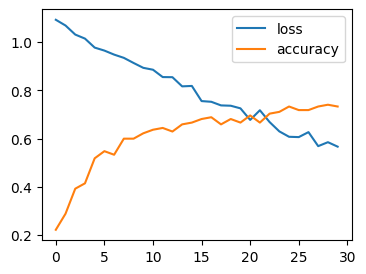

In [12]:
# Finally, we peek at the unseen data.
# Train a model on all the seen data previously used for in cross validation.
# Then test on unseen data for the first time.
final_model = None
X_train = X_seen  # don't need tf.convert_to_tensor()
y_train = y_seen
X_test  = X_unseen
y_test  = y_unseen
name = "MLP_final"
final_model   = make_model(name)
final_history = final_model.fit(X_train, y_train, batch_size=25, epochs=EPOCHS)
test_scores   = final_model.evaluate(X_test, y_test)
pd.DataFrame(final_history.history).plot(figsize=(4,3))
plt.show()

## Here is our final test accuracy:
Hight accuracy is not expected as we used a rather small neural network. 

In [13]:
print()
print('Test acc = %.2f loss = %.2f'%(test_scores[1],test_scores[0]))


Test acc = 0.73 loss = 0.53


TO DO:

Document the loss function.

Document RMSProp.

Document from_logits or one-hot encoding.

Document softmax and dropout.

Add more neurons.